# Experiment number 3 (cifar10):

## Cutting sliding window of 40% of the samples according to the metrics and comparing to random cutting and a normal model without cutting
## the metrics: EL2N, forget, flip, pred sum, std and km

### get dataset and metrics and print correlation


In [1]:
import os

import numpy as np
import pandas as pd
import torch
from torch import Tensor

from train import ModelManager, DIR_ROOT_SAVE, DIR_ROOT_LOG
from utils import get_loader, get_cifar10
import matplotlib.pyplot as plt

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 60
PRUNE = int(NUM_TRAIN * .4)

NOTEBOOK_NAME = 'prune_40p_cifar10'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')
PATH_KMEANS = os.path.join(DIR_ROOT_SAVE, 'k_means', 'cifar10.pt')
PATH_LOG = os.path.join(DIR_ROOT_LOG, NOTEBOOK_NAME, 'test_acc.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar10()
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), PRUNE, replace=False)
idx_sorted_km = np.argsort(km)

idx_sorted = {'el2n': idx_sorted_el2n, 'std': idx_sorted_std, 'pred_sum': idx_sorted_pred_sum,
              'forget': idx_sorted_forgetting, 'true_forget': idx_true_forget,
              'km': idx_sorted_km}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy(),
    'km': km
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,flip,forget,km
EL2N,1.000000,0.780107,-0.944299,0.658627,0.399751,0.529046
Std,0.780107,1.000000,-0.660269,0.586532,0.377763,0.496631
True p sum,-0.944299,-0.660269,1.000000,-0.627331,-0.350162,-0.460980
flip,0.658627,0.586532,-0.627331,1.000000,0.770378,0.394874
forget,0.399751,0.377763,-0.350162,0.770378,1.000000,0.253914
km,0.529046,0.496631,-0.460980,0.394874,0.253914,1.000000


In [2]:
# change to false in the first time you run this code
# after the first time the model will saved in models_data folder
already_trained = True

no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=already_trained)
if not already_trained:
    loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, True)
    no_prune.train(loader_train, loader_test, loader_test, EPOCHS)


# random
model_random = ModelManager(NUM_CLASSES, model_name='random', dir_=NOTEBOOK_NAME, load=already_trained)
if not already_trained:
    loader_train = get_loader(dataset_train, idx_random_prune, BATCH_SIZE, True)
    model_random.train(loader_train, loader_test, loader_test, EPOCHS)

# models = [no_prune, model_random]
start_points = [.0, .1, .2, .3, .4, .5, .51, .52, .53, .54, .55, .56, .57, .58, .59, .6]
acc_test: dict[str:dict[float:float]] = {'no_prune': {p: no_prune.data['test']['acc'] for p in start_points},
                                         'random': {p: model_random.data['test']['acc'] for p in start_points}}

print()
for name, idx in idx_sorted.items():
    acc_test[name] = {}
    for start_point in start_points:
        start = round(NUM_TRAIN * start_point)
        print(f'====     train model from {start} to {start + PRUNE} with {name} method    ======')
        if not already_trained:
            loader_train = get_loader(dataset_train, idx[start:start + PRUNE], BATCH_SIZE, True)
            model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_{int(start_point * 100)}', dir_=NOTEBOOK_NAME,
                                         load=False)
            model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
        else:
            model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_{int(start_point * 100)}', dir_=NOTEBOOK_NAME,
                                         load=True)
        acc_test[name][start_point] = model_manager.data['test']['acc']

        print()


====     train model from 0 to 20000 with el2n method    ======

====     train model from 5000 to 25000 with el2n method    ======

====     train model from 10000 to 30000 with el2n method    ======

====     train model from 15000 to 35000 with el2n method    ======

====     train model from 20000 to 40000 with el2n method    ======

====     train model from 25000 to 45000 with el2n method    ======

====     train model from 25500 to 45500 with el2n method    ======

====     train model from 26000 to 46000 with el2n method    ======

====     train model from 26500 to 46500 with el2n method    ======

====     train model from 27000 to 47000 with el2n method    ======

====     train model from 27500 to 47500 with el2n method    ======

====     train model from 28000 to 48000 with el2n method    ======

====     train model from 28500 to 48500 with el2n method    ======

====     train model from 29000 to 49000 with el2n method    ======

====     train model from 29500 to 495

In [3]:
acc_test['flip'] = acc_test.pop('forget')
acc_test['forget'] = acc_test.pop('true_forget')
acc_test['km'] = acc_test.pop('km')

acc_test.keys()

dict_keys(['no_prune', 'random', 'el2n', 'std', 'pred_sum', 'flip', 'forget', 'km'])

### compare the results according to metrics


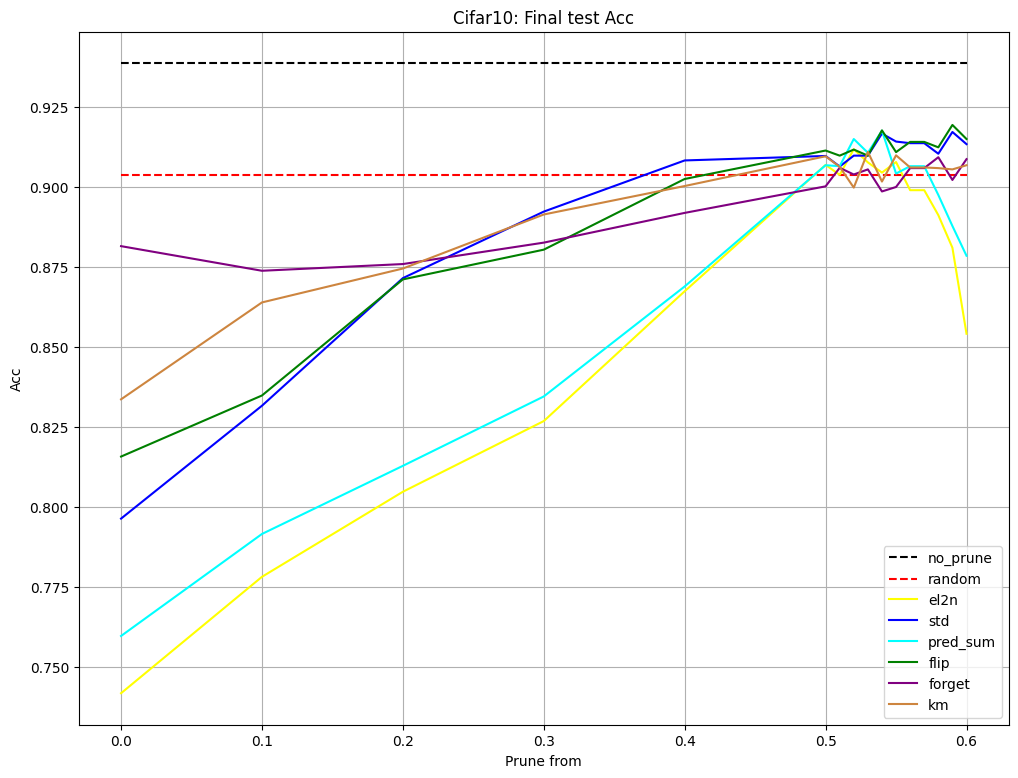

In [4]:
plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'darkorange', 'deeppink')
#          no       rand    el2n     std     sum     flip      forget   km      k-100         k-1000

markers = ('dashed', 'solid')
for i, prune_method in enumerate(acc_test):
    plt.plot(start_points, [acc_test[prune_method][p] for p in start_points], label=prune_method, c=colors[i],
             linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune from')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()

In [5]:
import pickle

with open(os.path.join(DIR_ROOT_SAVE, 'cifar10_40_slide_graph'), 'wb') as f:
    pickle.dump(acc_test, f)